### Lecture 6, Melodic segmentation features

Melodic segmentation using Local Boundary Detection Model (LBDM)

Cambouropoulos, E. (2001). The local boundary detection model (LBDM) and its application in the study of expressive timing. In Proc. of the International Computer Music Conference (ICMC), pages 232-235.

Implemented as in [boundary.m](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/boundary.m) of [Miditoolbox](https://github.com/miditoolbox/1.1)

In [1]:
from music21 import *
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [2]:
#Let's read a midi file, check its content
wholeTrack = converter.parse('../data/melody/segmentation/hicaz--sarki--aksak--su_karsiki_dagda--dede_efendi.mid')
#For segmentation we will only consider the first 4 bars
firstPart=wholeTrack.measures(1, 4)

Next two cells are simply for printing and plotting to understand the content of the file
(not required for melodic segmentation)

[('A', 69, 0.5), ('B-', 70, 0.5), ('A', 69, 1.0), ('B-', 70, 0.5), ('C#', 73, 0.5), ('B-', 70, 1.5), ('C#', 73, 0.5), ('D', 74, 0.5), ('C#', 73, 1.0), ('D', 74, 0.5), ('E', 76, 0.5), ('D', 74, 1.5), ('E', 76, 0.75), ('F#', 78, 0.25), ('G', 79, 0.5), ('A', 81, 0.5), ('G', 79, 0.5), ('F', 77, 0.5), ('E', 76, 0.5), ('D', 74, 0.5), ('E', 76, 0.5), ('C#', 73, 0.5), ('B-', 70, 0.25), ('A', 69, 0.25), ('E', 76, 0.5), ('D', 74, 0.25), ('C#', 73, 0.25), ('C#', 73, 0.25), ('B-', 70, 0.25), ('B-', 70, 0.25), ('A', 69, 0.25), ('A', 69, 1.5)]


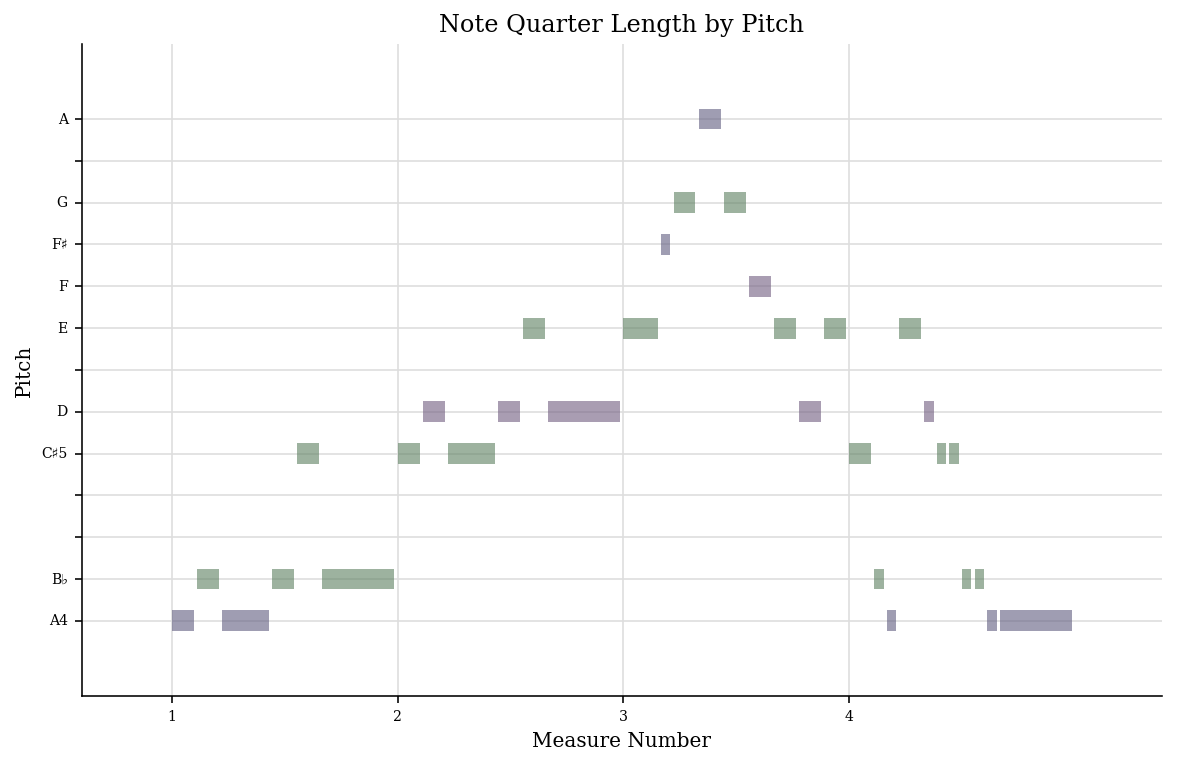

In [3]:
#Note sequence and piano-roll for the first 4 measures
firstPart.plot()
noteSequence=([(note.name,note.midi,note.duration.quarterLength) for note in firstPart.recurse().notes])
noteMidi=np.array([note.midi for note in firstPart.recurse().notes])
noteDurs=np.array([note.duration.quarterLength for note in firstPart.recurse().notes])
print(noteSequence)

Pitch class distribution (quarter length note durations)


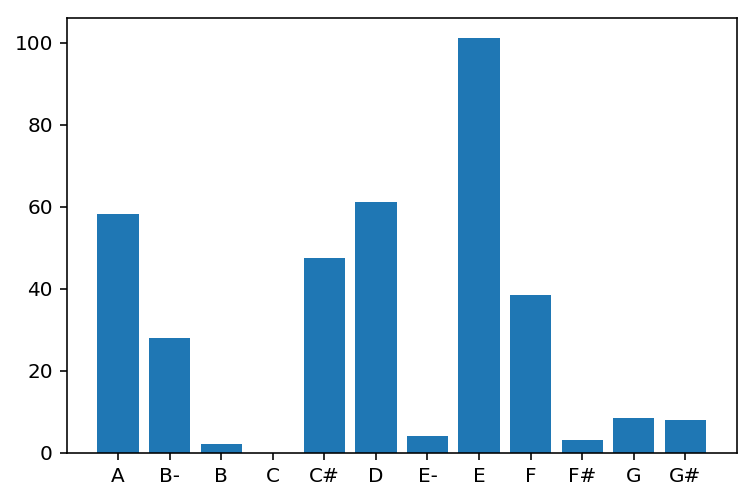

In [4]:
#Computing histogram ourselves [not relevant for melodic segmentation, just for fun and exercise]
noteNames=['A','B-','B','C','C#','D','E-','E','F', 'F#','G','G#']
noteDurations=np.zeros((len(noteNames),))
songNotesStream=wholeTrack.recurse().notes
hist={}
for currentNote in songNotesStream:
    noteDurations[noteNames.index(currentNote.name)]+=currentNote.duration.quarterLength

plt.bar(range(len(noteNames)), noteDurations, align='center')
plt.xticks(range(len(noteNames)), noteNames)
print('Pitch class distribution (quarter length note durations)')

### LBDM

In [5]:
#Implementing LBDM as in Miditoolbox (boundary.m)
pitch_profile=np.abs(noteMidi[1:]-noteMidi[:-1])#Miditoolbox variable 'pp'
onsets=[]#Miditoolbox variable 'on'
offsets_org=[]
durations=[]
for bar in firstPart[0]:
    for note in bar:
        if note.duration.quarterLength>0:#avoid data without duration, not a note event
            onsets.append(bar.offset+note.offset)
            durations.append(note.duration.quarterLength)
            offsets_org.append(note.offset)
onsets=np.array(onsets)
durations=np.array(durations)
offsets=onsets+durations#Miditoolbox variable 'off'

ioi_profile=onsets[1:]-onsets[:-1]#Miditoolbox variable 'po'
rest_profile = onsets[1:]-offsets[:-1]#Miditoolbox variable 'pr'
rest_profile = (rest_profile+np.abs(rest_profile))/2#half wave rect. (max(0,x) in Miditoolbox)

# degrees of change [see boundary.m]
rp = np.abs(pitch_profile[1:]-pitch_profile[:-1]) / (0.000001+pitch_profile[1:]+pitch_profile[:-1])
rp=np.append(rp,0)
ro = [np.abs(ioi_profile[1:]-ioi_profile[:-1]) / (0.000001+ioi_profile[1:]+ioi_profile[:-1])]
ro=np.append(ro,0)
rr = [np.abs(rest_profile[1:]-rest_profile[:-1]) / (0.000001+rest_profile[1:]+rest_profile[:-1])]
rr=np.append(rr,0)
# strengths
sp = pitch_profile*np.append(0,rp[:-1]+rp[1:])
if np.max(sp)>0.1:
    sp = sp/np.max(sp)
so = ioi_profile*np.append(0,ro[:-1]+ro[1:])
if np.max(so)>0.1:
    so = so/np.max(so)
sr = rest_profile*np.append(0,rr[:-1]+rr[1:])
if np.max(sr)>0.1:
    sr = sr/np.max(sr)

# overall profile
b = np.append(1,0.25*sp + 0.5*so + 0.25*sr)

In [6]:
#Plotting 3 experts' melodic segment annotations for the first 4 bars
Image(url= "../data/melody/segmentation/expertSegmentation_bars1_4.jpg")

In [7]:
#Comparing plot obtained using Miditoolbox boundary.m (in Matlab)
Image(url= "../data/melody/segmentation/LBDM_midiToolbox_bars1_4.png")

...


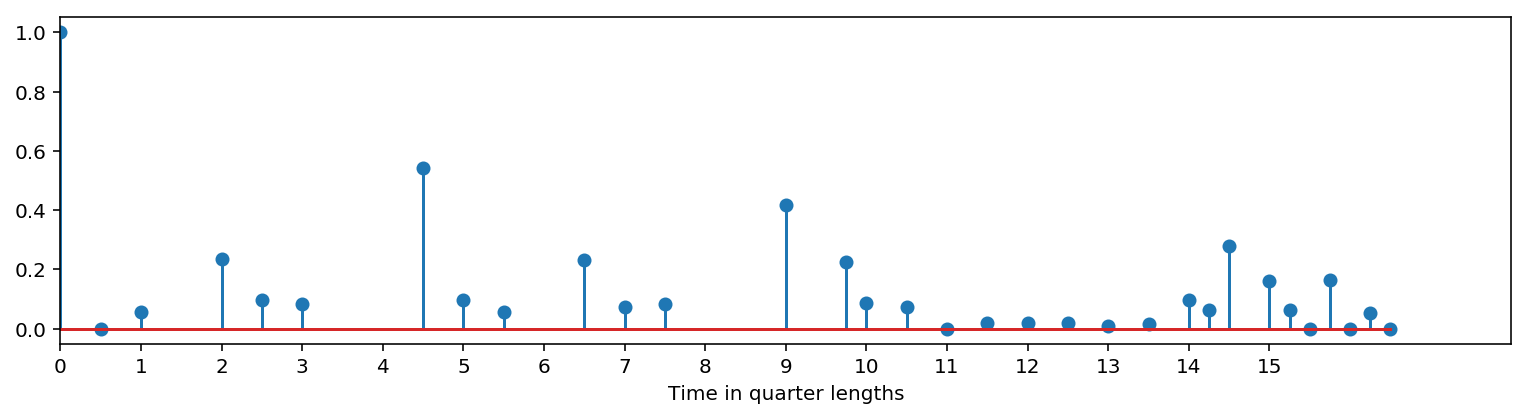

In [8]:
#Let's plot our computation result for boundary strengths
plt.figure(figsize=(13, 3))
plt.stem(np.cumsum(np.append(0,durations[:-1])),b)
plt.xlabel('Time in quarter lengths')
plt.xlim(0, 18)
plt.xticks(np.arange(16))
print('...')